### Librairies

In [1]:
import requests
import lxml.html as lh
import pandas as pd
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [2]:
# URL
url_inception = 'https://www.allocine.fr/film/fichefilm-143692/critiques/spectateurs/'
url_sonic = 'https://www.allocine.fr/film/fichefilm-281203/critiques/spectateurs/'
# URI-SUFFIX
uri_pages = '?page='
# Number of pages to read
nbPages = 100

tags = ['//span[@class="stareval-note"]', \
       '//div[@class="content-txt review-card-content"]']
cols = ['Note', \
        'Commentaire']

In [3]:
def get_page(url):
    page = requests.get(url)
    doc = lh.fromstring(page.content)
    
    #Get the web data via xpath
    content = []
    for i in range(len(tags)):
        content.append(doc.xpath(tags[i]))
    
    # Gather the data into a Pandas DataFrame array
    df_liste = []
    for j in range(len(tags)):
        tmp = pd.DataFrame([content[j][i].text_content().strip() for i in range(len(content[i]))], columns=[cols[j]])
        tmp['key'] = tmp.index
        df_liste.append(tmp)
 
    # Build the unique Dataframe with one tag (xpath) content per column
    liste = df_liste[0]
    for j in range(len(tags)-1):
        liste = liste.join(df_liste[j+1], on='key', how='left', lsuffix='_l', rsuffix='_r')
        liste['key'] = liste.index
        del liste['key_l']
        del liste['key_r']
 
    return liste        

In [4]:
def getPages(_nbPages, _url):
    liste_finale = pd.DataFrame()
    for i in range (_nbPages):
        liste = get_page(_url + uri_pages + str(i+1))
        liste_finale = pd.concat([liste_finale, liste], ignore_index=True)
    return liste_finale
 
df_inception = getPages(nbPages, url_inception)

In [6]:
df_inception.head()

,Note,Commentaire,key
0,"5,0",Après le chef d'oeuvre super-héroïque The Dark...,0
1,"5,0",C’est fou ce qu’on aime détester Christopher N...,1
2,"5,0",CHEF D’ŒUVRE ! Le film est absolument parfait ...,2
3,"5,0","Un film aussi novateur que complexe, dont la m...",3
4,"3,5",Le meilleur blockbuster de 2010 a pour thème l...,4


In [7]:
df_sonic = getPages(nbPages, url_sonic)
df_sonic.head()

,Note,Commentaire,key
0,"4,0",une bonne suite pour les aventures de sonic au...,0
1,"5,0",Cette suite de sonic est incroyable !Le fan qu...,1
2,"3,0",Malgré deux nouveaux personnages de l'univers ...,2
3,"4,0",Très bon film ont retrouve ce qui fait l’espri...,3
4,"4,0","Super film de ouf, le fait que Knuckles soit d...",4


### Concaténation des dataframes

In [8]:
df_sonic.shape

(1221, 3)

In [9]:
df_inception.shape

(1500, 3)

In [10]:
df_films = pd.concat([df_sonic, df_inception])

In [11]:
df_films.reset_index(inplace=True)

In [12]:
df_films.tail()

,index,Note,Commentaire,key
2716,1495,"2,5",Agréablement surpris! Des effets spéciaux impr...,10
2717,1496,"4,0",E-NOR-ME !!!!Le jeu de TOUS les acteurs est tr...,11
2718,1497,"5,0",Qu'elle film!!Je conseil a tous ce chef d'oeuv...,12
2719,1498,"5,0","Bon, DiCaprio commence vraiment à me gonfler! ...",13
2720,1499,"5,0","Après avoir vu ce film, je n'ai qu'une conclus...",14


In [13]:
df_films.shape

(2721, 4)

### Nettoyage des commentaires

#### Elimination de la ponctuation (regex) et transformation en minuscule

In [14]:
df_films['Commentaire'] = df_films['Commentaire'].replace("[^\w\s]", " ", regex = True).str.replace("\d+", '', regex=True).str.lower()

In [15]:
df_films.head()

,index,Note,Commentaire,key
0,0,"4,0",une bonne suite pour les aventures de sonic au...,0
1,1,"5,0",cette suite de sonic est incroyable le fan qu...,1
2,2,"3,0",malgré deux nouveaux personnages de l univers ...,2
3,3,"4,0",très bon film ont retrouve ce qui fait l espri...,3
4,4,"4,0",super film de ouf le fait que knuckles soit d...,4


#### Enlever les stop words

In [16]:
SW = stopwords.words('french')
df_films['Commentaire_sans_SW'] = df_films['Commentaire'].apply(lambda x:' '.join([word for word in x.split() if word not in SW]))


In [17]:
df_films

,index,Note,Commentaire,key,Commentaire_sans_SW
0,0,"4,0",une bonne suite pour les aventures de sonic au...,0,bonne suite aventures sonic cinéma deja premie...
1,1,"5,0",cette suite de sonic est incroyable le fan qu...,1,cette suite sonic incroyable fan ravi quand jo...
2,2,"3,0",malgré deux nouveaux personnages de l univers ...,2,malgré deux nouveaux personnages univers jeu v...
3,3,"4,0",très bon film ont retrouve ce qui fait l espri...,3,très bon film retrouve fait esprit sonic film ...
4,4,"4,0",super film de ouf le fait que knuckles soit d...,4,super film ouf fait knuckles côté eggman début...
...,...,...,...,...,...
2716,1495,"2,5",agréablement surpris des effets spéciaux impr...,10,agréablement surpris effets spéciaux impressio...
2717,1496,"4,0",e nor me le jeu de tous les acteurs est tr...,11,e nor jeu tous acteurs très bien mario cotilla...
2718,1497,"5,0",qu elle film je conseil a tous ce chef d oeuv...,12,film conseil a tous chef oeuvre fera passer h ...
2719,1498,"5,0",bon dicaprio commence vraiment à me gonfler ...,13,bon dicaprio commence vraiment gonfler fais pa...


#### Lemmentiser

In [18]:
import spacy
nlp = spacy.load('fr_core_news_md')

2022-05-03 20:59:21.209082: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-03 20:59:21.209141: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [19]:
df_films['lemmatizer'] = df_films['Commentaire_sans_SW'].apply(lambda x: [y.lemma_ for y in nlp(x)])

In [20]:
df_films.head()

,index,Note,Commentaire,key,Commentaire_sans_SW,lemmatizer
0,0,"4,0",une bonne suite pour les aventures de sonic au...,0,bonne suite aventures sonic cinéma deja premie...,"[bon, suite, aventure, sonic, cinéma, deja, pr..."
1,1,"5,0",cette suite de sonic est incroyable le fan qu...,1,cette suite sonic incroyable fan ravi quand jo...,"[ce, suite, sonic, incroyable, fan, ravir, qua..."
2,2,"3,0",malgré deux nouveaux personnages de l univers ...,2,malgré deux nouveaux personnages univers jeu v...,"[malgré, deux, nouveau, personnage, univer, je..."
3,3,"4,0",très bon film ont retrouve ce qui fait l espri...,3,très bon film retrouve fait esprit sonic film ...,"[très, bon, film, retrouve, faire, esprit, son..."
4,4,"4,0",super film de ouf le fait que knuckles soit d...,4,super film ouf fait knuckles côté eggman début...,"[super, film, ouf, faire, knuckles, côté, eggm..."


##### Transformation des listes dans la colonne "lemmatizer" en chaine de caractères

In [21]:
df_films['lemmatizer'] = df_films["lemmatizer"].apply(lambda x: ' '.join(str(y) for y in x))
df_films.head()

,index,Note,Commentaire,key,Commentaire_sans_SW,lemmatizer
0,0,"4,0",une bonne suite pour les aventures de sonic au...,0,bonne suite aventures sonic cinéma deja premie...,bon suite aventure sonic cinéma deja premier f...
1,1,"5,0",cette suite de sonic est incroyable le fan qu...,1,cette suite sonic incroyable fan ravi quand jo...,ce suite sonic incroyable fan ravir quand joue...
2,2,"3,0",malgré deux nouveaux personnages de l univers ...,2,malgré deux nouveaux personnages univers jeu v...,malgré deux nouveau personnage univer jeu vidé...
3,3,"4,0",très bon film ont retrouve ce qui fait l espri...,3,très bon film retrouve fait esprit sonic film ...,très bon film retrouve faire esprit sonic film...
4,4,"4,0",super film de ouf le fait que knuckles soit d...,4,super film ouf fait knuckles côté eggman début...,super film ouf faire knuckles côté eggman débu...


#### Remplacement des accents

In [22]:
df_films['lemmatizer'] = df_films['lemmatizer'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [23]:
df_films

,index,Note,Commentaire,key,Commentaire_sans_SW,lemmatizer
0,0,"4,0",une bonne suite pour les aventures de sonic au...,0,bonne suite aventures sonic cinéma deja premie...,bon suite aventure sonic cinema deja premier f...
1,1,"5,0",cette suite de sonic est incroyable le fan qu...,1,cette suite sonic incroyable fan ravi quand jo...,ce suite sonic incroyable fan ravir quand joue...
2,2,"3,0",malgré deux nouveaux personnages de l univers ...,2,malgré deux nouveaux personnages univers jeu v...,malgre deux nouveau personnage univer jeu vide...
3,3,"4,0",très bon film ont retrouve ce qui fait l espri...,3,très bon film retrouve fait esprit sonic film ...,tres bon film retrouve faire esprit sonic film...
4,4,"4,0",super film de ouf le fait que knuckles soit d...,4,super film ouf fait knuckles côté eggman début...,super film ouf faire knuckles cote eggman debu...
...,...,...,...,...,...,...
2716,1495,"2,5",agréablement surpris des effets spéciaux impr...,10,agréablement surpris effets spéciaux impressio...,agreablement surprendre effet special impressi...
2717,1496,"4,0",e nor me le jeu de tous les acteurs est tr...,11,e nor jeu tous acteurs très bien mario cotilla...,e nor jeu tout acteur tres bien mario cotillar...
2718,1497,"5,0",qu elle film je conseil a tous ce chef d oeuv...,12,film conseil a tous chef oeuvre fera passer h ...,film conseil avoir tout chef oeuvre faire pass...
2719,1498,"5,0",bon dicaprio commence vraiment à me gonfler ...,13,bon dicaprio commence vraiment gonfler fais pa...,bon dicaprio commencer vraiment gonfler fai pa...


#### Stemmatiser

In [246]:
#Méthode non utilisé pour éviter de perdre le sens des mots
#stemmer = SnowballStemmer("french")
#df_films['stemmed'] = df_films['Commentaire_sans_SW'].str.split().apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
#df_films.head()

#### Définition des features et de la target

In [24]:
X = df_films['lemmatizer']
y = df_films['Note'].replace(',', '.', regex=True).astype('float')

y.dtype

dtype('float64')

In [25]:
y = y.mask(y<3.0, 0)
y = y.mask(y>=3.0, 1)

y.value_counts()

1.0    2409
0.0     312
Name: Note, dtype: int64

#### Fractionnement du jeu de données en train et test

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
y_train.value_counts()
y_test.value_counts()

1.0    483
0.0     62
Name: Note, dtype: int64

In [27]:
y_train.shape

(2176,)

In [28]:
y_test.shape

(545,)

### Word Cloud

In [29]:
df_wc = pd.concat([X, y], axis = 1)
df_wc.head()

,lemmatizer,Note
0,bon suite aventure sonic cinema deja premier f...,1.0
1,ce suite sonic incroyable fan ravir quand joue...,1.0
2,malgre deux nouveau personnage univer jeu vide...,1.0
3,tres bon film retrouve faire esprit sonic film...,1.0
4,super film ouf faire knuckles cote eggman debu...,1.0


#### Avis positifs

In [30]:
#Récupération des avis positifs
avis_positif = df_wc["lemmatizer"][df_wc["Note"] == 1.0]

avis_positif

0       bon suite aventure sonic cinema deja premier f...
1       ce suite sonic incroyable fan ravir quand joue...
2       malgre deux nouveau personnage univer jeu vide...
3       tres bon film retrouve faire esprit sonic film...
4       super film ouf faire knuckles cote eggman debu...
                              ...                        
2715    film reflexion originalite inegalable si film ...
2717    e nor jeu tout acteur tres bien mario cotillar...
2718    film conseil avoir tout chef oeuvre faire pass...
2719    bon dicaprio commencer vraiment gonfler fai pa...
2720    apres avoir voir film conclusion christopher n...
Name: lemmatizer, Length: 2409, dtype: object

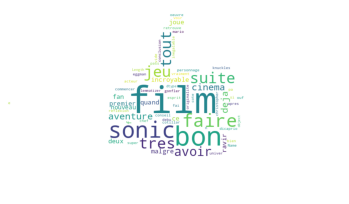

In [31]:
from PIL import Image
import numpy as np

mask_pos = np.array(Image.open("thumb_up.png"))
mask_pos[mask_pos == 1] = 255

WC_pos = WordCloud(background_color="white", mask = mask_pos).generate(str(avis_positif))
plt.imshow(WC_pos)
plt.axis('off')
plt.show()

#### Avis négatifs

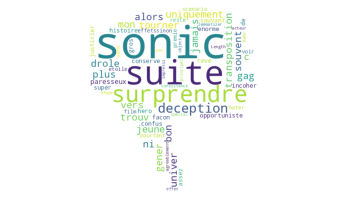

In [32]:
mask_neg = np.array(Image.open("thumb_down.png"))
mask_neg[mask_neg == 1] = 255

WC_neg = WordCloud(background_color="white", mask = mask_neg).generate(str(df_wc["lemmatizer"][df_wc["Note"]==0.0]))
plt.imshow(WC_neg)
plt.axis('off')
plt.show()

#### Count Vectorizer

In [63]:
cv = CountVectorizer(lowercase=False, min_df=0.1)
cv = cv.fit(X_train)
cv_matrix = cv.transform(X_train)
cv_matrix.shape

(2102, 91)

In [64]:
#Create bag of words
X_train_bow = pd.DataFrame(cv_matrix.toarray(), index = X_train.index.values, columns = cv.get_feature_names_out())
X_train_bow

,acteur,action,adorer,aller,apprecier,apres,attendre,aussi,autre,avoir,...,superbe,tail,tant,toujours,tout,tres,trop,voir,vouloir,vraiment
2383,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2024,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2373,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
805,0,0,0,1,1,0,0,0,1,1,...,0,0,0,0,1,2,0,0,0,1
975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0,0,0,0,1,0,0,1,1,0,...,0,1,1,0,2,0,0,0,0,0
1095,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1964,0,2,0,0,0,0,0,1,0,4,...,0,0,0,0,2,1,0,0,0,0
625,0,0,0,0,1,0,0,1,1,0,...,0,1,1,0,2,0,0,0,0,0


#### A faire
- Word Cloud des avis positifs & négatifs
- Régression logistique  
- Count Vectorize sur le X_test

#### Modèle de régression logistique

In [69]:
model_LR = LogisticRegression(solver="liblinear", random_state=0)

#Entrainement du modèle
model_LR.fit(X_train_bow, y_train)

LogisticRegression(random_state=0, solver='liblinear')

#### Conversion du X_test en matrice

In [65]:
#cv2 = CountVectorizer(lowercase=False, min_df=0.1)

cv_X_test = cv.transform(X_test)
cv_X_test.shape

(526, 91)

In [67]:
X_test_bow = pd.DataFrame(cv_X_test.toarray(), index = X_test.index, columns = cv.get_feature_names_out())
X_test_bow

,acteur,action,adorer,aller,apprecier,apres,attendre,aussi,autre,avoir,...,superbe,tail,tant,toujours,tout,tres,trop,voir,vouloir,vraiment
1042,0,1,0,0,3,3,0,2,0,11,...,0,1,0,0,3,7,1,3,2,1
825,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1920,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
1242,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,1,1,0,0,0,0
1695,0,1,0,0,0,0,0,0,0,3,...,0,0,0,1,2,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1816,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
364,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,2,0,0,0,0
113,0,0,1,0,0,0,0,1,0,1,...,0,0,1,1,1,0,1,0,0,0
2193,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,2,1,0


In [70]:
#Prédiction du y
y_pred = model_LR.predict(X_test_bow)

#### Accuracy

In [82]:
accuracy = model_LR.score(X_test_bow, y_test)
print(f"La précision est de {accuracy}")

La précision est de 0.903041825095057


#### Matrice de confusion

In [84]:
matrice_confusion = confusion_matrix(y_test, y_pred)
matrice_confusion

array([[ 22,  40],
       [ 11, 453]])

In [89]:
tn, fp, fn, tp = matrice_confusion.ravel()

print(f"True negative = {tn}, \nFalse positive = {fp}, \nFalse negative = {fn}, \nTrue positive = {tp}")

True negative = 22, 
False positive = 40, 
False negative = 11, 
True positive = 453


#### Test d'un word cloud

In [52]:
com_1 = df_sonic.iloc[0, 1]

In [64]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/perrine/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [74]:

SW = stopwords.words('french')
#SW.append('Cette')
#SW.append('fille')
sw2 = ['déjà', 'formeune', 'toute', 'trop', 'suite']

In [72]:
for i in sw2:
    SW.append(i)

In [73]:
print(SW)

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

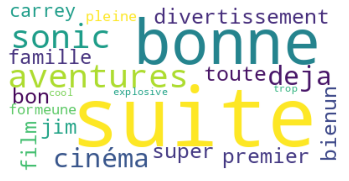

In [67]:

WC=WordCloud(background_color = 'white',stopwords = SW).generate(com_1)

plt.imshow(WC)
plt.axis("off")
plt.show()